## Paper Ratings Noise

Explore how we can filter out papers that have noisy ratings, i.e. papers with too high
variability in their ratings. We assume that those papers are less reliable to use.

In [1]:
from collections.abc import Iterable, Sequence
from pathlib import Path
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator
from pydantic import BaseModel, ConfigDict, TypeAdapter

In [2]:
class Paper(BaseModel):
    model_config = ConfigDict(frozen=True)

    title: str
    abstract: str
    introduction: str
    ratings: Sequence[int]


DatasetAdapter = TypeAdapter(list[Paper])

In [3]:
input_file = Path("../output/asap_extracted.json")

data = DatasetAdapter.validate_json(input_file.read_text())
len(data)

1758

In [4]:
ratings = pd.Series([r.ratings for r in data])
ratings

0          [6, 4, 6]
1          [7, 6, 7]
2          [7, 7, 4]
3          [7, 6, 6]
4       [4, 7, 5, 4]
            ...     
1753       [4, 7, 7]
1754       [4, 8, 7]
1755       [7, 7, 8]
1756       [6, 4, 6]
1757       [5, 6, 7]
Length: 1758, dtype: object

In [5]:
variances = pd.Series([np.var(r.ratings) for r in data])
print("min: ", variances.min())
print("mean:", variances.mean())
print("max: ", variances.max())
print("zero:", variances[variances == 0].size)

min:  0.0
mean: 1.2033853179117682
max:  11.759999999999998
zero: 301


In [6]:
def plot(
    data: Iterable[float],
    label: str,
    *,
    mode: Literal["count", "percentage", "cumulative"],
    bins: int = 20,
) -> None:
    """Print plot of binned continuous value. 99% generated by Claude.

    Args:
        data: Any sequence/iterator/generator/list of numbers
        label: Title for the plot at the top
        mode:
            - count: plain frequency count
            - percentage: normalised count (percentage of the total)
            - cumulative: accumulated percentage of the total
        bins: Self-explanatory. The plot will use the max value of each bin
            for the x-axis labels.
    """

    series = pd.Series(data)
    bins = pd.cut(series, bins=bins)
    freq = bins.value_counts().sort_index()

    if mode == "percentage":
        freq = freq / len(series) * 100
    elif mode == "cumulative":
        freq = (freq.cumsum() / len(series) * 100).sort_index()

    # Adjust figure size based on number of bins
    fig_width = max(8, len(freq) * 0.5)
    fig_height = 4 + (
        len(freq) * 0.1
    )  # Increase height to accommodate horizontal labels
    plt.figure(figsize=(fig_width, fig_height))

    ax = plt.gca()
    if mode == "cumulative":
        freq.plot(kind="line", marker="o", ax=ax)
    else:
        freq.plot(kind="bar", ax=ax)

    plt.title(f"{label.capitalize()} {mode.capitalize()} Frequency Distribution")
    plt.xlabel(label)

    if mode == "count":
        plt.ylabel("Frequency")
        ax.yaxis.set_major_locator(MultipleLocator(max(1, freq.max() // 10)))
    else:
        plt.ylabel(f"{mode.capitalize()} Percentage")
        ax.yaxis.set_major_locator(MultipleLocator(5))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1f}%"))

        # Adjust y-axis range for cumulative mode
        y_min = max(0, freq.min() - 5)  # Start 5% below the minimum, but not below 0
        y_max = min(100, freq.max() + 5)  # End 5% above the maximum, but not above 100
        plt.ylim(y_min, y_max)

    # Ensure all x-axis labels are shown, using only the upper bound of each interval
    x_labels = [f"{interval.right:.2f}" for interval in freq.index]
    plt.xticks(range(len(freq)), x_labels, rotation=0, ha="center")

    plt.grid(True, axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    # Adjust bottom margin to prevent label cutoff
    plt.subplots_adjust(bottom=0.2)

    plt.show()

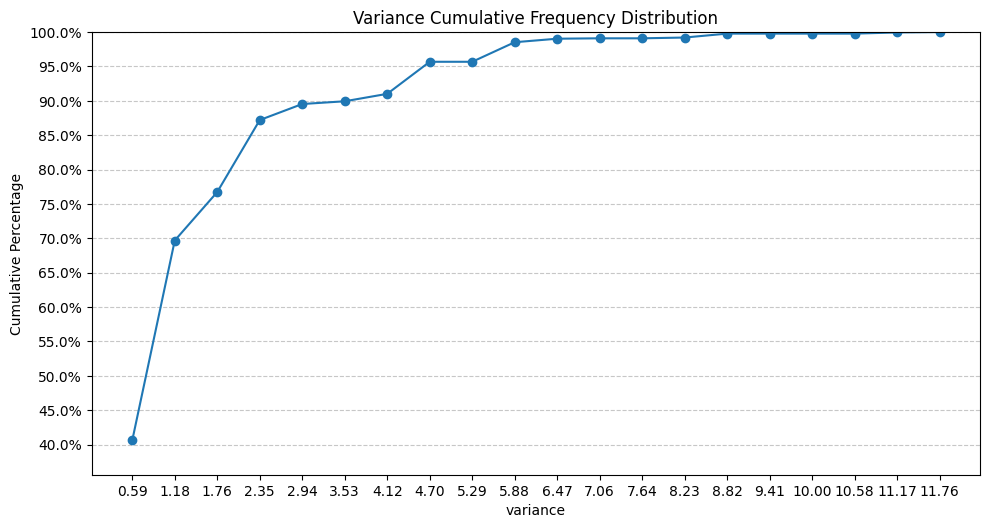

In [7]:
variances = pd.Series([np.var(r.ratings) for r in data])
plot(variances, "variance", mode="cumulative")

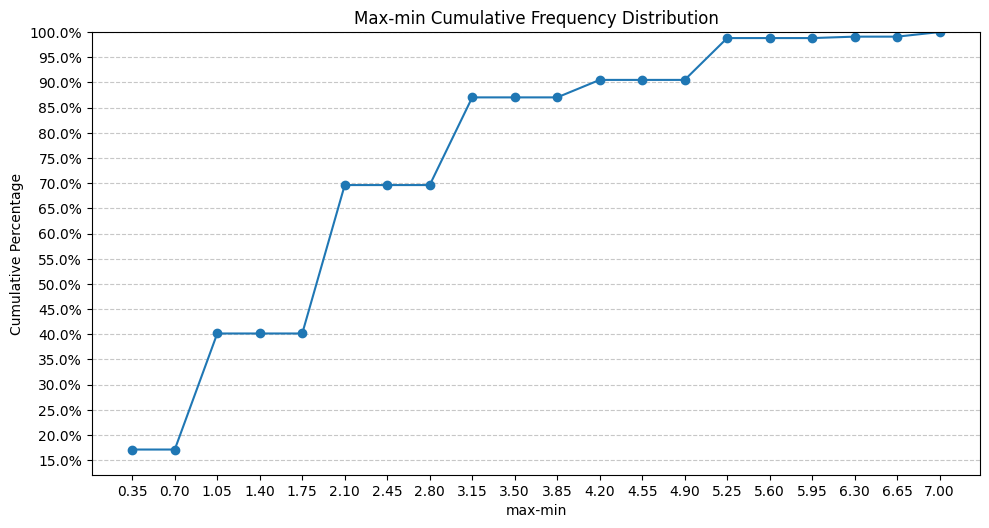

In [8]:
maxmin = pd.Series([max(r.ratings) - min(r.ratings) for r in data])
plot(maxmin, "max-min", mode="cumulative")

In [9]:
print(variances.map(lambda x: x <= 2).value_counts(normalize=True))
print(variances.map(lambda x: x <= 2).value_counts())

True     0.86405
False    0.13595
Name: proportion, dtype: float64
True     1519
False     239
Name: count, dtype: int64


In [10]:
print(maxmin.map(lambda x: x <= 2).value_counts(normalize=True))
print(maxmin.map(lambda x: x <= 2).value_counts())

True     0.696246
False    0.303754
Name: proportion, dtype: float64
True     1224
False     534
Name: count, dtype: int64


In [11]:
print(maxmin.map(lambda x: x <= 3).value_counts(normalize=True))
print(maxmin.map(lambda x: x <= 3).value_counts())

True     0.870307
False    0.129693
Name: proportion, dtype: float64
True     1530
False     228
Name: count, dtype: int64
